# Exploratory Data Analysis (EDA) Cookie Data

The goal of this notebook is to conduct an exploratory data analysis, of the interaction data collected with the cookie on [https://tv2fyn.dk](tv2fyn.dk), and some additional context features coming from the Bazo API. The data featured in this notebook was collected from the 16th to the 22nd of May. It should be noted though, that the data collection process is a continuous process, going on as long as the recommendations algorithm is in use.

First some necessary libraries will be imported, the data will be imported, and the `device_id` column will be anonymized with a hashing algorithm. Thereafter, the different variables will be visualized in a univariate, bivariate and possibly multivariate space, to get a sense of the different distributions and any patterns that may form. The hope is that by exploring the variables by themselves, and in connection to one another, any irregularities can be found and resolved, and any interesting patterns can be used in the further work with creating a recommendations algorithm.

In [95]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import hashlib
import matplotlib.pyplot as plt

## Data Import and First Look

The columns `date` and `release_date` is converted from UNIX timestamps to datetime, to make them more readable. Further, labels are assigned to `day_of_week` which was created with the MySQL function `DAYOFWEEK()`. 

In [154]:
df = pd.read_csv('database_contents.csv').iloc[:, 1:].dropna() # dropping index column.
df['device_id'] = df['device_id'].astype(str).apply(lambda x: hashlib.sha256(x.encode()).hexdigest())

# converting unix timestamp to datetime and assigning string labels to day_of_week
df[['date', 'release_date']] = df[['date', 'release_date']].apply(pd.to_datetime, unit='s') 
df['day_of_week'] = df['day_of_week'].map({1:'Sunday', 2:'Monday', 3:'Tuesday', 4:'Wednesday', 5:'Thursday', 6:'Friday', 7:'Saturday'})
# Converting times from utc to cest
df['time'] = (pd.to_datetime(df['time'], unit='s') + pd.Timedelta('2:00:00')).dt.strftime('%H:%M:%S')
df['date'] = df['date'].dt.tz_localize('utc').dt.tz_convert('Europe/Copenhagen')

In [155]:
df.dtypes

day_of_week                                 object
time                                        object
date             datetime64[ns, Europe/Copenhagen]
device_id                                   object
article_id                                  object
title                                       object
section                                     object
location                                    object
release_date                        datetime64[ns]
avg_sentiment                              float64
affinity                                   float64
dtype: object

To ensure that the transformations worked as intended, and to get a first glance of the data, the first few rows will be printed.

In [156]:
df.head() #printing the first few rows

,day_of_week,time,date,device_id,article_id,title,section,location,release_date,avg_sentiment,affinity
0,Thursday,11:03:32,2022-05-12 11:03:32+02:00,529ba088c75866921cd98ff705218491659e4425615a99...,28658ec7-95cf-4eac-b17b-ce2d8d808333,Coronaplagede dagtilbud kan begrænse åbningsti...,Samfund,Fyn,2022-01-10 05:11:26,0.114407,1.6258
1,Monday,21:41:37,2022-05-16 21:41:37+02:00,4ddbb3db565e2e74da1ac5ca90ae249fa526ca6ecd4db7...,60cbd63c-2da1-4809-ae78-139188191e3a,Historisk gods på Sydfyn brændte for anden gang,112,Svendborg,2022-05-14 13:52:14,-0.019210,2.0008
2,Monday,11:08:37,2022-05-16 11:08:37+02:00,1faf7fa75bcbf8f7e925b977b20167355f4fddcce9025f...,60cbd63c-2da1-4809-ae78-139188191e3a,Historisk gods på Sydfyn brændte for anden gang,112,Svendborg,2022-05-14 13:52:14,-0.019210,0.0072
3,Monday,09:49:27,2022-05-16 09:49:27+02:00,be5e2c092d32cd7a2d86dcb63f9850482cc14931131cef...,3f4b7006-d4ef-49f6-b79b-85f8662ced29,Ny akutlægehelikopter i Nordjylland vil gavne Fyn,112,Fyn,2018-06-29 12:35:00,0.069514,0.5645
4,Monday,09:50:30,2022-05-16 09:50:30+02:00,73b3c3a6e0a02a6a8d46398ec59bc6df9ffd3d8a1a1e1e...,0f0ca592-ed61-4f22-8b3e-951cac53bd05,Hvad med tandlægen?Forening ønsker at åbne for...,Sundhed,Fyn,2020-04-09 06:07:00,0.064413,0.0086


In [157]:
print(f'The dataset contains {len(df):,} interactions between \
{len(np.unique(df.device_id)):,} unique users and {len(np.unique(df.article_id)):,} unique articles. \
The average user has therefore visited/read {round(len(df)/len(np.unique(df.device_id)), 2)} articles.')

The dataset contains 120,833 interactions between 66,872 unique users and 5,111 unique articles. The average user has therefore visited/read 1.81 articles.


That is quite a lot of users and not many article reads per user in average, however, the distribution might be skewed, with a good portion of users only seen once. This could be handled by only including users who have read at least two articles. There is also a large number of unique articles, considering that this data only is one week's worth of interactions. This might indicate that there is a great variety in the articles different users read. There is both benefits and disadvantages to this, as it might be harder to find similarities between users, but easier to instill diversity and serendipity in recommendations.

We will return to this later, first let's visualize the different columns in univariate distribution plots, and discuss the distributions.

## Visualizing Univariate Distributions

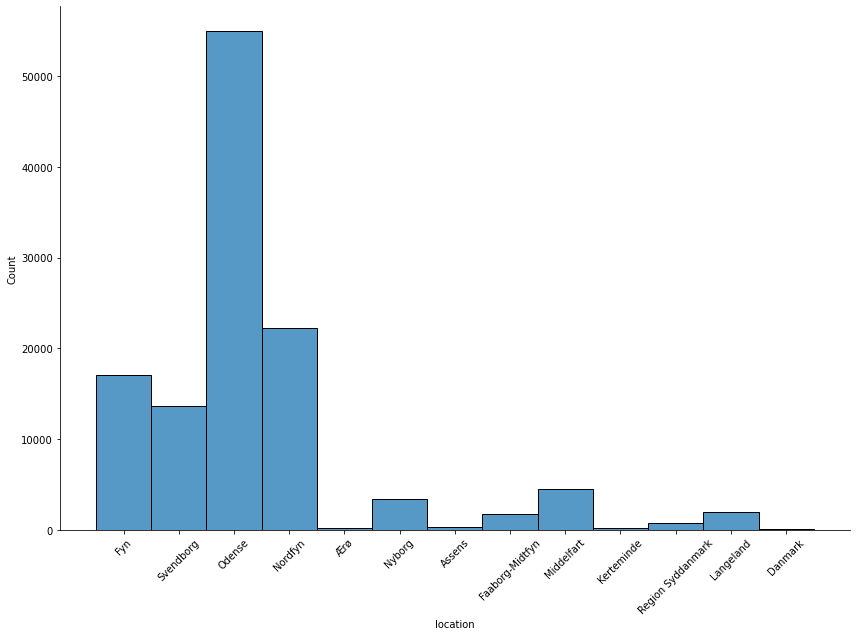

In [158]:
sns.displot(data=df, x='location', height=8, aspect=12/8)
plt.xticks(rotation=45)
plt.show()

Most of the articles read has the location Odense which makes sense, as Odense is the largest city on Fyn. Apart from Odense Nordfyn, Fyn and Svendborg are quite popular.

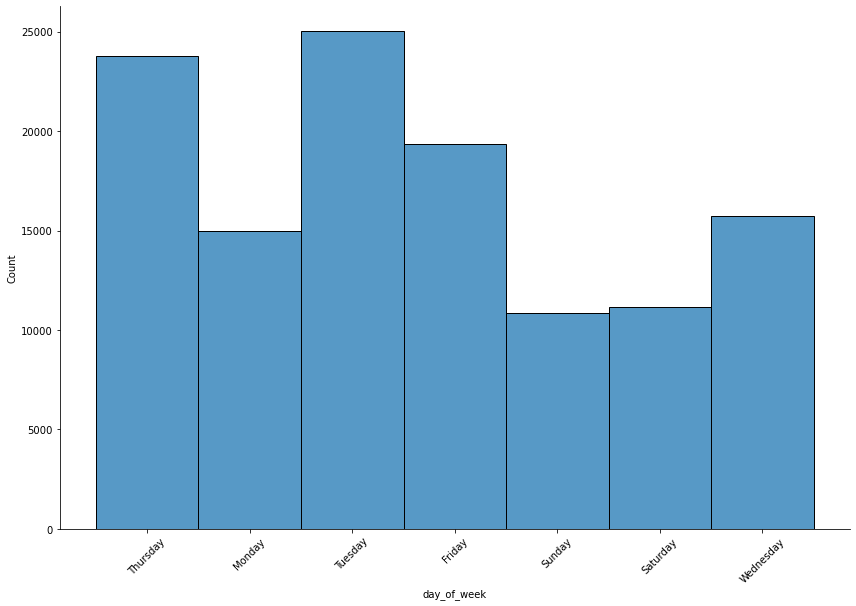

In [159]:
sns.displot(data=df, x='day_of_week', height=8, aspect=12/8)
plt.xticks(rotation=45)
plt.show()

Thursdays and Tuesdays has the most visitors, but the number of visitors are quite evenly distributed.

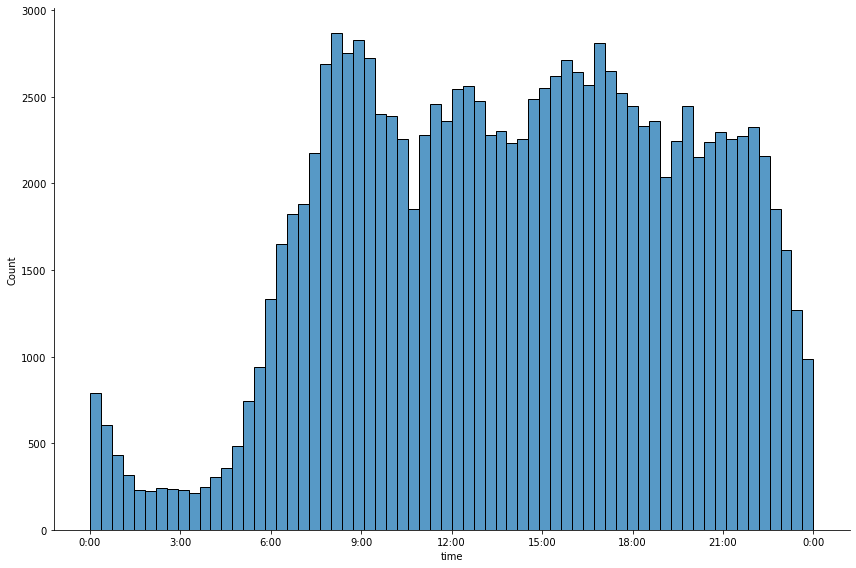

In [160]:
sns.displot(data=pd.to_datetime(df['time']), height=8, aspect=12/8)
plt.xticks(plt.xticks()[0],['0:00', '3:00', '6:00', '9:00', '12:00', '15:00', '18:00', '21:00', '0:00'])
plt.show()

The number of visitors are quite evenly distributed throughout the day, with a few users reading in the middle of the night.

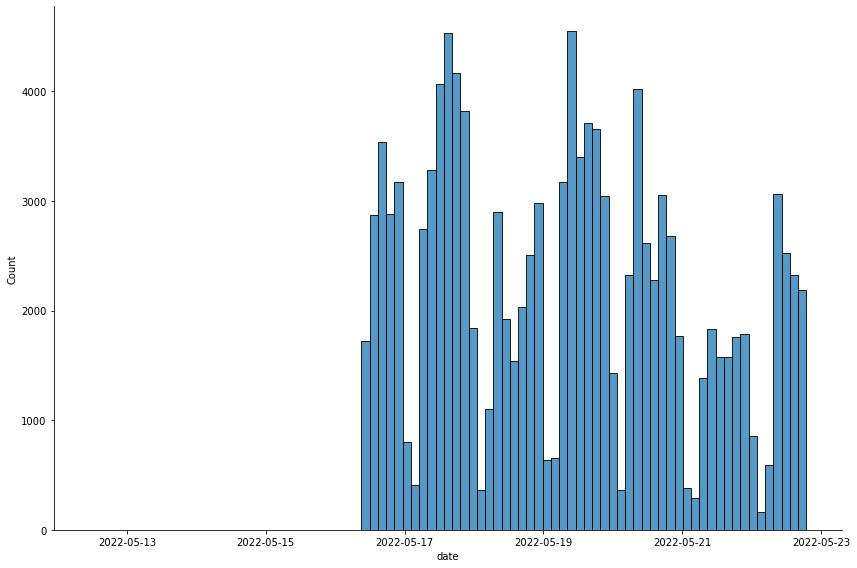

In [161]:
sns.displot(data=df, x='date', height=8, aspect=12/8)
plt.show()

A mixture of the two previous plots, showing a pretty even distribution between the days.

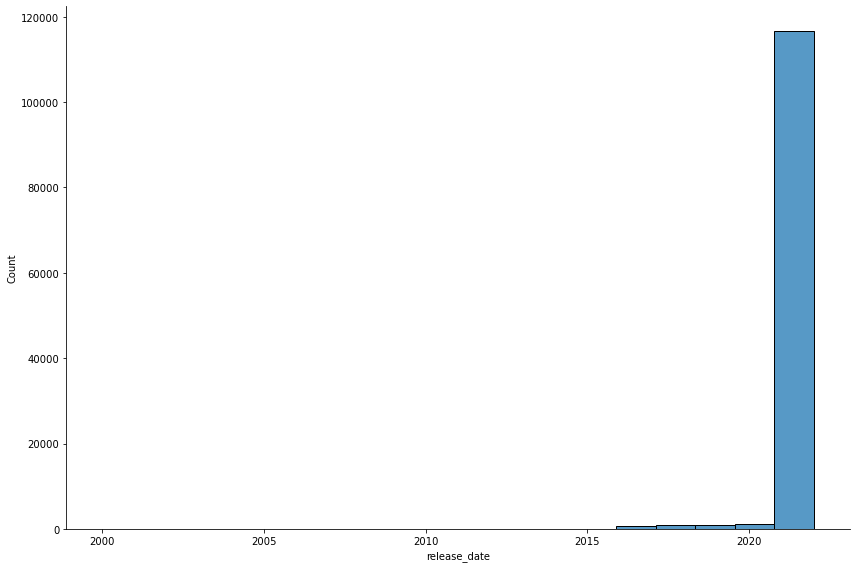

In [202]:
sns.displot(data=df.release_date.dt.year, height=8, aspect=12/8)
plt.show()

It seems that most articles read are from 2022, but some articles read are older, the oldest being from 2000.

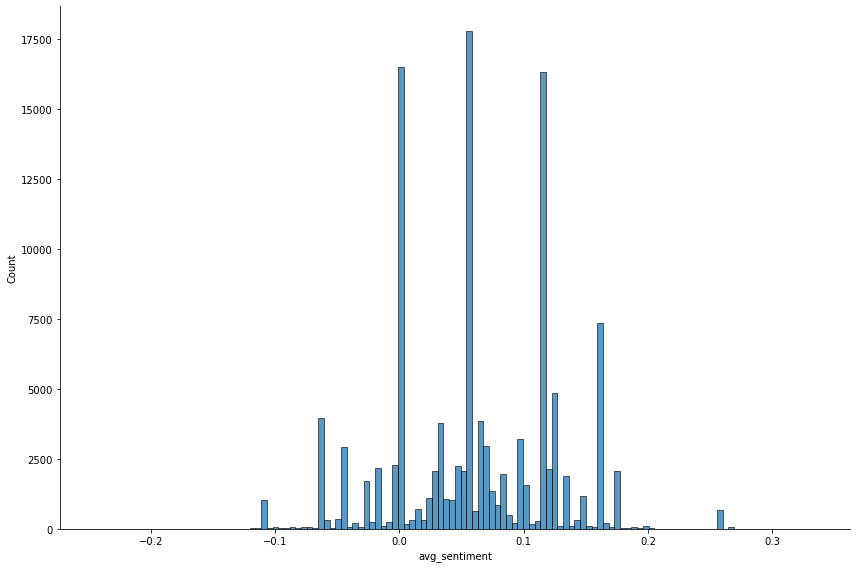

In [203]:
sns.displot(data=df, x='avg_sentiment', height=8, aspect=12/8)
plt.show()

The average sentiment of articles read are all very close to zero, however, the distribution are centered in the positive end.

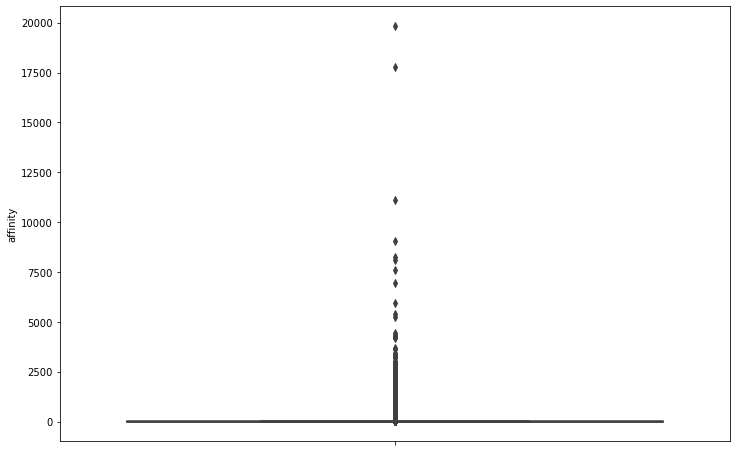

In [209]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df, y='affinity')
plt.show()

The affinity score couldn't be plotted with a displot, probably because there are some extreme outliers. These should be dealt with before model training, to ensure the model isn't skewed to overestimate certain articles. This is most likely due to a measurement error during data collection.

One way of detecting outliers is by standardizing the values i.e., calculating Z values and deeming any absolute value above a threshold of 3 an outlier. 

In [215]:
def detect_outlier(data):
    outliers=[]
    threshold=3
    mean = np.mean(data)
    std = np.std(data)
    
    
    for y in data:
        z_score= (y - mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

outliers = detect_outlier(df['affinity'])
print(f'With a threshold of ABS(Z) > 3 there are {len(outliers)} outliers.')
print(f'The largest outlier value is {max(outliers)}')
print(f'The lowest outlier value is {min(outliers)}')

With a threshold of ABS(Z) > 3 there are 444 outliers.
The largest outlier value is 19824.627
The lowest outlier value is 407.0595


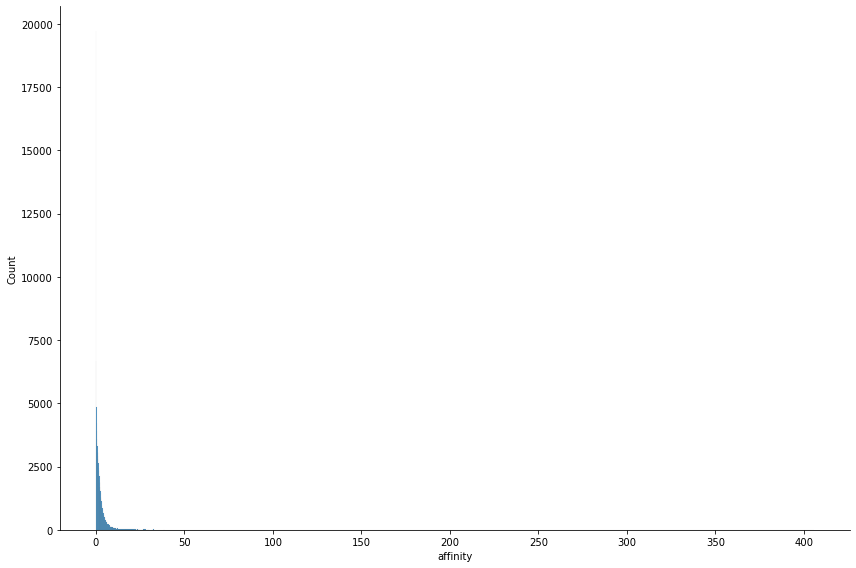

In [222]:
sns.displot(data = df['affinity'][df.affinity < min(outliers)], height=8, aspect=12/8)
plt.show()

There is still a lot of values in the low end, however, the algorithm should also be able to rank articles, that aren't interesting to a user as a low value. 

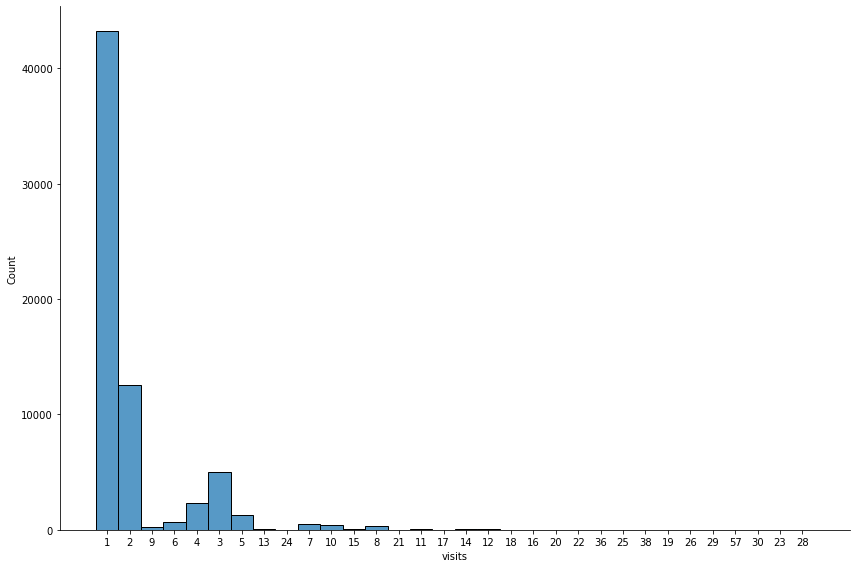

In [238]:
n_visits = df.groupby('device_id').size().reset_index(name='visits').astype(str)
sns.displot(n_visits, x='visits', height=8, aspect=12/8)
plt.show()

Looking at the number of visits each user has i.e., number of articles they've read, it's clear that a big portion of users 40,000+ only has read one article. In this case it might be a good idea, to exclude users who have only read one article, in favour of users who have read several, as no patterns can be found for one-time users. These users might be included in consecutive training rounds, as more data is gathered.